# Serial Test over USB
Connecting to a USB serial port to get data from an Arduino. To install the software run:

`apt-get install python-serial`

In [1]:
%ls /dev/ttyACM*

/dev/ttyACM0


## Setup the serial configuration
Check that the serial device printed by the command above matches the `portPath` below:

In [27]:
import serial
import time
import csv
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from datetime import datetime, date
from IPython.display import clear_output
import ipywidgets as widgets
 
portPath = "/dev/ttyACM0"       # Must match value shown on Arduino IDE
baud = 115200                   # Must match Arduino baud rate
timeout = 5                     # Seconds
filename = str(date.today()) + " data.csv"
max_num_readings = 8
num_signals = 1
 
 
 
def create_serial_obj(portPath, baud_rate, tout):
    """
    Given the port path, baud rate, and timeout value, creates and returns a pyserial object.
    """
    return serial.Serial(portPath, baud_rate, timeout = tout)

In [3]:
def read_serial_data(serial):
    """
    Given a pyserial object (serial). Outputs a list of lines read in from the serial port
    """
    #serial.flushInput()
    serial.reset_input_buffer()
    
    serial_data = []
    readings_left = True
    timeout_reached = False
    
    #Send data to start the transfer
    serial.write(1)
    #Wait for the data to be ready
    time.sleep(2)
    
    while readings_left and not timeout_reached:
        serial_line = serial.readline()
        if serial_line == b'':
            timeout_reached = True
        else:
            serial_data.append(serial_line)
            if len(serial_data) == max_num_readings:
                readings_left = False
        
    return serial_data

In [4]:
headers = ["PM 0.3","PM 0.5","PM 1.0","PM 2.5","PM 5.0","PM 10.0","Temp","Pressure","Humidity","CO2",
           "BME680 VOC","QM9 VOC","MiCS5524 VOC","CCS811 VOC","Date"]
try:
    df = pd.read_csv(filename,names=headers,skiprows = 1)
    df
except:
    df = pd.DataFrame() #Create an empty data frame to append to later

In [5]:
df

""


In [6]:
print ("Creating serial object...")
serial_obj = create_serial_obj(portPath, baud, timeout)
 
print ("Reading serial data...")
serial_data = read_serial_data(serial_obj)
#print serial_data.len()

Creating serial object...
Reading serial data...


In [7]:
def is_number(string):
    """
    Given a string returns True if the string represents a number.
    Returns False otherwise.
    """
    try:
        float(string)
        return True
    except ValueError:
        return False
        
def clean_serial_data(data):
    """
    Given a list of serial lines (data). Removes all characters.
    Returns the cleaned list of lists of digits.
    Given something like: ['0.5000,33\r\n', '1.0000,283\r\n']
    Returns: [[0.5,33.0], [1.0,283.0]]
    """
    clean_data = []
    
    for line in data:
        line_data = line.decode("utf-8", "ignore").strip()
        #line_data = re.findall("\d*\.\d*|\d*",line) # Find all digits
        #line_data = [float(element) for element in line_data if is_number(element)] # Convert strings to float
        #line_data = line_data datetime.now()
    clean_data.append(line_data)
        
    return clean_data

In [8]:
print("Cleaning data...")
clean_data =  clean_serial_data(serial_data)
clean_data_table = [clean_data]
clean_data_table

Cleaning data...


[['1749,501,83,8,0,0,32.24,1020.46,32.29,400,0.00,386,41,0']]

In [9]:
clean_data_table = pd.DataFrame([sub.split(",") for sub in clean_data])
clean_data_table['Date'] = [datetime.now()]
clean_data_table.columns = headers
clean_data_table

,PM 0.3,PM 0.5,PM 1.0,PM 2.5,PM 5.0,PM 10.0,Temp,Pressure,Humidity,CO2,BME680 VOC,QM9 VOC,MiCS5524 VOC,CCS811 VOC,Date
0,1749,501,83,8,0,0,32.24,1020.46,32.29,400,0.00,386,41,0,2020-05-30 22:54:17.194023


In [10]:
df = df.append(clean_data_table)
df

,PM 0.3,PM 0.5,PM 1.0,PM 2.5,PM 5.0,PM 10.0,Temp,Pressure,Humidity,CO2,BME680 VOC,QM9 VOC,MiCS5524 VOC,CCS811 VOC,Date
0,1749,501,83,8,0,0,32.24,1020.46,32.29,400,0.00,386,41,0,2020-05-30 22:54:17.194023


In [11]:
df.to_csv(filename,names=headers)

In [12]:
df = pd.read_csv(filename,names=headers,skiprows = 1)
df

,PM 0.3,PM 0.5,PM 1.0,PM 2.5,PM 5.0,PM 10.0,Temp,Pressure,Humidity,CO2,BME680 VOC,QM9 VOC,MiCS5524 VOC,CCS811 VOC,Date
0,1749,501,83,8,0,0,32.24,1020.46,32.29,400,0,386,41,0,2020-05-30 22:54:17.194023


In [13]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f')
df = pd.read_csv(filename, parse_dates=['Date'], date_parser=dateparse,index_col=0)
df

,PM 0.3,PM 0.5,PM 1.0,PM 2.5,PM 5.0,PM 10.0,Temp,Pressure,Humidity,CO2,BME680 VOC,QM9 VOC,MiCS5524 VOC,CCS811 VOC,Date
0,1749,501,83,8,0,0,32.24,1020.46,32.29,400,0,386,41,0,2020-05-30 22:54:17.194023


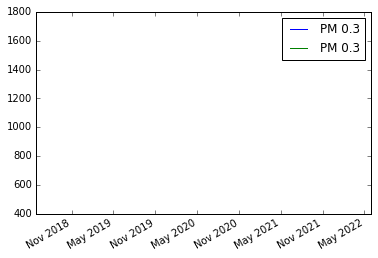

In [14]:
x = df['Date']
y1 = df['PM 0.3']
y2 = df['PM 0.5']
y3 = df['PM 1.0']
y4 = df['PM 2.5']
y5 = df['PM 5.0']
y6 = df['PM 10.0']

# plot
plt.cla()
plt.plot(x,y1, label='PM 0.3')
plt.plot(x,y2, label='PM 0.3')

plt.legend()
# beautify the x-labels
plt.gcf().autofmt_xdate()
plt.show()
plt.ioff()

In [42]:
keep_running = widgets.Checkbox()
keep_running = True
keep_running.description='Keep Running?'

def update_widget_value(keep_running):
    """
    Updates the running widget to stop the loop
    """
    print(keep_running)
    return keep_running

widgets.interactive(update_widget_value,keep_running=keep_running)
time.sleep(1)

while keep_running == True:
    serial_data = read_serial_data(serial_obj)
    print("Reading Data")
    clean_data =  clean_serial_data(serial_data)
    clean_data_table = pd.DataFrame([sub.split(",") for sub in clean_data],
                                    columns=["PM 0.3","PM 0.5","PM 1.0","PM 2.5","PM 5.0","PM 10.0",
                                             "Temp","Pressure","Humidity","BME680 VOC","QM9 VOC",
                                             "MiCS5524 VOC","CO2","CCS811 VOC"])
    clean_data_table['Date'] = [datetime.now()]
    df = df.append(clean_data_table)
    time.sleep(1)

AttributeError: 'bool' object has no attribute 'description'

In [43]:
df

,BME680 VOC,CCS811 VOC,CO2,Date,Humidity,MiCS5524 VOC,PM 0.3,PM 0.5,PM 1.0,PM 10.0,PM 2.5,PM 5.0,Pressure,QM9 VOC,Temp
0,0,0,400,2020-05-30 22:54:17.194023,32.29,41,1749,501,83,0,8,0,1020.46,386,32.24
0,473,11,48,2020-05-30 23:01:50.552337,32.33,391,1524,425,68,2,4,4,1020.48,9.33,32.24
0,465,9,50,2020-05-30 23:01:57.889754,32.25,393,1503,412,65,2,4,4,1020.48,12.48,32.24
0,463,9,51,2020-05-30 23:02:05.214974,32.20,394,1452,408,69,2,6,4,1020.48,15.54,32.25
0,461,9,45,2020-05-30 23:02:12.534016,32.15,394,1452,408,69,2,6,4,1020.46,18.76,32.25
0,480,12,45,2020-05-30 23:04:27.056470,32.31,394,1524,409,70,0,8,4,1020.46,14.64,32.25
0,679,42,51,2020-05-30 23:11:37.811457,32.37,417,1449,402,80,0,10,0,1020.48,10.27,32.26
0,675,41,42,2020-05-30 23:11:44.878039,32.29,416,1581,453,89,0,4,2,1020.50,13.39,32.27
0,665,40,42,2020-05-30 23:11:51.945436,32.24,415,1662,478,94,0,4,2,1020.48,16.91,32.29
0,675,41,42,2020-05-30 23:11:59.012557,32.23,413,1590,445,92,0,12,0,1020.48,20.00,32.30


In [ ]:
df.to_csv(filename,names=headers)
df

In [47]:
import asyncio
import functools
 
def event_handler(loop, stop=False):
    print('Event handler called')
    if stop:
        print('stopping the loop')
        loop.stop()

if __name__ == '__main__':
    loop = asyncio.get_event_loop()
    try:
        loop.call_soon(functools.partial(event_handler, loop))
        print('starting event loop')
        loop.call_soon(functools.partial(event_handler, loop, stop=True))
 
        loop.run_forever()
    finally:
        print('closing event loop')
        loop.close()

closing event loop


RuntimeError: Event loop is closed

In [50]:
loop.call_soon(functools.partial(event_handler, loop))

RuntimeError: Event loop is closed